# 0. Imports

In [1]:
%cd ../../..

/workspace/pixel-art-character-generation


In [3]:
from sampling.conditional_probability_path import GaussianConditionalProbabilityPath
from sampling.sampleable import PixelArtSampler
from sampling.noise_scheduling import LinearAlpha, LinearBeta
from models.unet import PixelArtUNet
from training.trainer import UnguidedTrainer
from training.evaluation import FID
from diff_eq.ode_sde import UnguidedVectorFieldODE
from diff_eq.simulator import EulerSimulator
from utils.visualization import visualize_training_logs

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Train

In [4]:
if 'unet' in locals():
    del unet
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Initialize probability path
sampler = PixelArtSampler('dataset/images').to(device)
path = GaussianConditionalProbabilityPath(
    p_data=sampler,
    p_simple_shape = [4, 128, 128],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
unet = PixelArtUNet(
    channels = [128, 256, 512, 1024],
    num_residual_layers = 2,
    t_embed_dim = 256,
    midcoder_dropout_p=0.2
)

# Initialize evaluation metric
metric = FID(
    feature=2048,
    normalize=True,
    image_size=(299, 299)
)

# Initialize trainer
trainer = UnguidedTrainer(
    path=path,
    model=unet,
    experiment_dir="training/experiments/unet_large",
    eval_metric=metric
)


# Train :D
trainer.train(
    device=device,
    num_epochs=20000,
    batch_size=64,
    lr=1e-4,
    weight_decay=5e-4,
    validate_every=500,
    val_timesteps=200,
    resume=False,
    lr_warmup_steps_frac=0.1,
    num_images_to_save=3,
    save_images_every=500
)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 63.6MB/s]


Model size: 295.0486 MiB


100%|██████████| 20000/20000 [6:15:32<00:00,  1.13s/it, train_loss=0.0454, val_metric=375.4126, best_val_metric=341.9795 (epoch 15999)]   


# 2. Visualize model performance over time

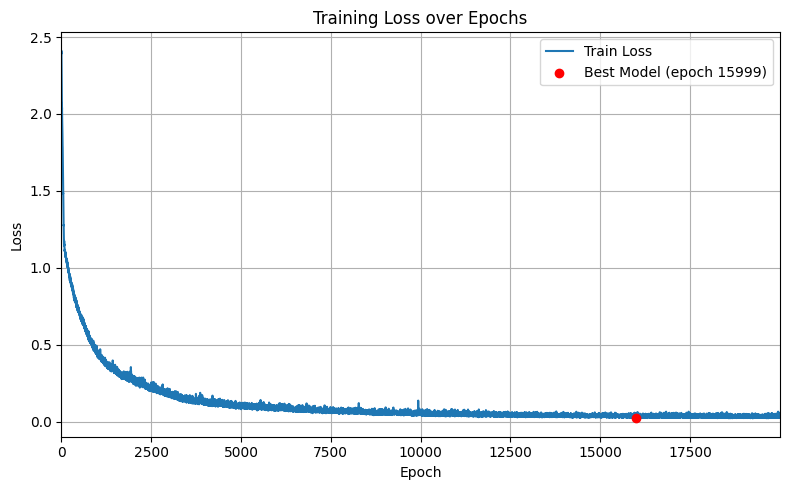

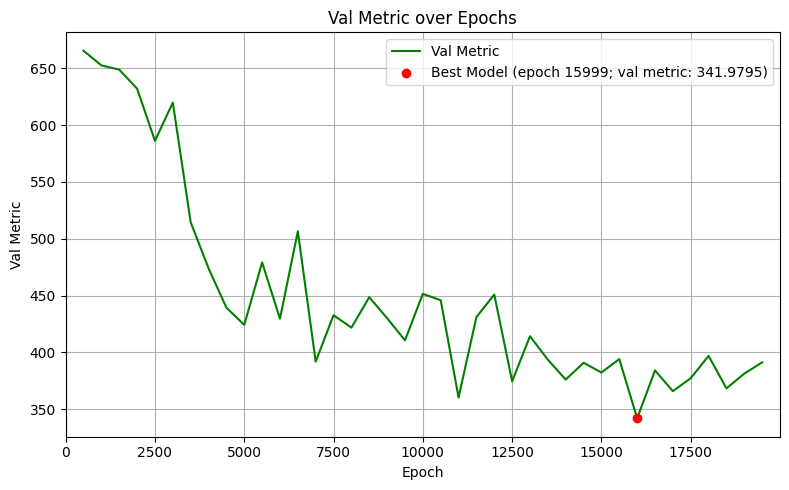

In [5]:
visualize_training_logs(log_path="training/experiments/unet_large/training_log.csv", scale="linear")

# 3. Visualize results

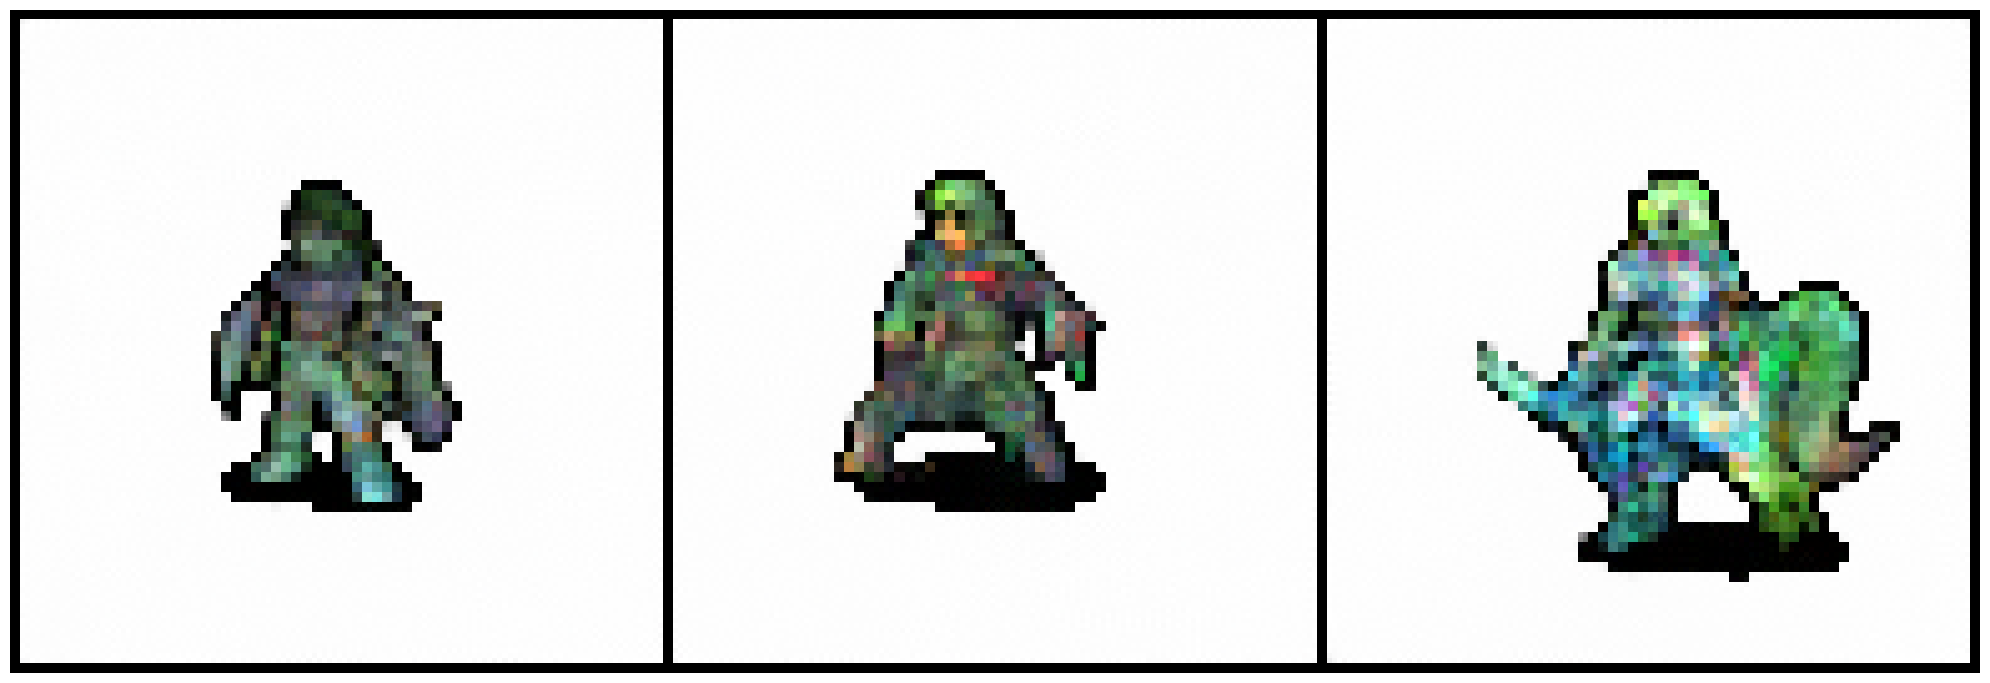

In [28]:
# Parameters
num_samples = 3
num_timesteps = 300

# Load model from checkpoints
cp = torch.load('training/experiments/unet_large/best_model.pt', map_location=device)
model = PixelArtUNet(
    channels = [128, 256, 512, 1024],
    num_residual_layers = 2,
    t_embed_dim = 256,
    midcoder_dropout_p=0.2
).to(device)
model.load_state_dict(cp["model_state"])
model.eval()

# Load path
sampler = PixelArtSampler('dataset/images').to(device)
path = GaussianConditionalProbabilityPath(
    p_data=sampler,
    p_simple_shape = [4, 128, 128],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Simulate
ts = torch.linspace(0, 1, num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
x0 = path.p_simple.sample(num_samples).to(device)  # (num_samples, 4, 128, 128)

# Run simulation
ode = UnguidedVectorFieldODE(model)
simulator = EulerSimulator(ode)
x1 = simulator.simulate(x0, ts)  # (num_samples, 4, 128, 128)

# Keep RGBA
rgba = x1[:, :4]  # (num_samples, 4, H, W)

# Separate channels
rgb = rgba[:, :3]
alpha = rgba[:, 3:4]  # shape (N, 1, H, W)
rgb = (rgb + 1) / 2  # → [0, 1]
alpha = (alpha + 1) / 2  # → [0, 1]

# Composite over white background
white_bg = torch.ones_like(rgb)  # all ones = white
img = alpha * rgb + (1 - alpha) * white_bg

# Make grid
grid = make_grid(img, nrow=num_samples, normalize=False)

# Plot
plt.figure(figsize=(20, 10))
plt.imshow(grid.permute(1, 2, 0).clamp(0, 1).cpu().numpy())
plt.axis("off")
plt.tight_layout()
plt.show()

# 4. Evaluate on the test set

In [29]:
trainer = UnguidedTrainer(
    path=path,
    model=model,
    experiment_dir="training/experiments/unet_large",
    eval_metric=metric
)

test_fid = trainer.evaluate(batch_size=64, device=device, num_timesteps=100, mode="test")

print(f"FID on the test set: {test_fid:.4f}")

FID on the test set: 352.9062
